<a href="https://colab.research.google.com/github/ggierlik/dw_matrix_road_sign/blob/master/day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign


In [0]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import os
import datetime

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((4410, 32, 32, 3), (4410,))

In [0]:
len(np.unique(y_train))

43

In [0]:
to_categorical(y_train)[3232] # konwersja do macierzy 43 kolumnami gdzie w kolumna n to 1


array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
# modyfikujemy y_train (ndim to rozmiar) -- if spowoduje, że transformacja wykona się tylko raz
y_train.ndim
if y_train.ndim == 1: y_train = to_categorical(y_train)
y_train.ndim
y_train.shape
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
y_train.ndim
np.unique(y_train)

array([0., 1.], dtype=float32)

In [0]:
X_train.shape
input_shape = X_train.shape[1:] #obcina pierwszy element
num_classes = y_train.shape[1]

model = Sequential([
  Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
  Flatten(),
  Dense(num_classes, activation='softmax')
])
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 43)                2476843   
Total params: 2,478,635
Trainable params: 2,478,635
Non-trainable params: 0
_________________________________________________________________
1088/1088 [==============================] - 3s 3ms/step - loss: 8.9720 - accuracy: 0.8100


In [0]:
def get_cnn_v1(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
  ])
    
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(X_train, y_train, 
            batch_size=params_fit.get('batch_size', 128), #rozmiar paczki wejściowej
            epochs=params_fit.get('epochs', 5),
            verbose=params_fit.get('verbose', 1),
            validation_data=params_fit.get('validation_data', (X_train, y_train)),
            callbacks=[tensorboard_callback]
  )

  return model



In [0]:

def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [0]:
#model = get_cnn_v1(input_shape, num_classes)

def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)

  return predict(model_trained, X_test, y_test)

model = train_and_predict(get_cnn_v1(input_shape, num_classes))


Epoch 1/5
272/272 [==============================] - 2s 9ms/step - loss: 31.9700 - accuracy: 0.7182 - val_loss: 0.2517 - val_accuracy: 0.9355
Epoch 2/5
272/272 [==============================] - 2s 8ms/step - loss: 0.2365 - accuracy: 0.9445 - val_loss: 0.1899 - val_accuracy: 0.9561
Epoch 3/5
272/272 [==============================] - 2s 8ms/step - loss: 0.1718 - accuracy: 0.9575 - val_loss: 0.1655 - val_accuracy: 0.9651
Epoch 4/5
272/272 [==============================] - 2s 8ms/step - loss: 0.1302 - accuracy: 0.9695 - val_loss: 0.0842 - val_accuracy: 0.9788
Epoch 5/5
270/272 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9738

KeyboardInterrupt: ignored

In [0]:
predict(model_trained, X_test, y_test)

0.8206349206349206

<BarContainer object of 43 artists>

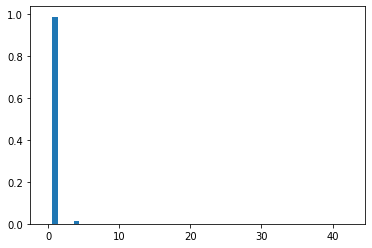

In [0]:
plt.bar(range(43), y_pred_prob[400])

In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [0]:
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (30km/h)'

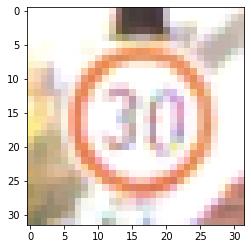

In [0]:

plt.imshow(X_test[400]);


In [0]:
y_pred_prob[400]

array([7.7296364e-10, 9.8571032e-01, 2.0904702e-07, 7.1544446e-07,
       1.4013216e-02, 2.7547262e-04, 1.0632427e-26, 1.2012700e-13,
       6.7619768e-24, 5.4613388e-13, 1.2669823e-21, 2.0127750e-19,
       4.1878167e-28, 4.6600985e-21, 6.8611233e-26, 4.2044409e-24,
       1.3334396e-30, 2.1627076e-33, 2.3806463e-20, 7.7957172e-36,
       8.2928271e-30, 1.2327123e-23, 7.3411882e-36, 1.2593059e-22,
       6.2021841e-23, 2.7358902e-18, 7.1008417e-29, 1.2776994e-28,
       4.5733728e-25, 2.9670441e-23, 3.7189215e-32, 1.1948155e-19,
       2.0330156e-34, 0.0000000e+00, 5.9764584e-27, 1.8399741e-25,
       1.2938459e-28, 1.5333236e-36, 4.3013384e-32, 0.0000000e+00,
       7.2473592e-29, 2.5648232e-25, 1.6754458e-37], dtype=float32)

In [0]:
def get_cnn_v2(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax'),
  ])
  

In [0]:
model = train_and_predict(get_cnn_v2(input_shape, num_classes))
model

Epoch 1/5
272/272 [==============================] - 2s 9ms/step - loss: 6.7192 - accuracy: 0.2372 - val_loss: 1.6712 - val_accuracy: 0.5560
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 1.6244 - accuracy: 0.5295 - val_loss: 0.8591 - val_accuracy: 0.7963
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.9268 - accuracy: 0.7224 - val_loss: 0.3542 - val_accuracy: 0.9129
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.5728 - accuracy: 0.8276 - val_loss: 0.1907 - val_accuracy: 0.9609
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.4260 - accuracy: 0.8719 - val_loss: 0.1450 - val_accuracy: 0.9721


0.8775510204081632

In [0]:
def get_cnn_v3(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax'),
  ])

train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 2.0341 - accuracy: 0.5596 - val_loss: 0.2987 - val_accuracy: 0.9365
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.4624 - accuracy: 0.8655 - val_loss: 0.1033 - val_accuracy: 0.9779
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2469 - accuracy: 0.9290 - val_loss: 0.0459 - val_accuracy: 0.9885
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1730 - accuracy: 0.9499 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1262 - accuracy: 0.9624 - val_loss: 0.0191 - val_accuracy: 0.9952


0.9700680272108844

In [0]:
def get_cnn_v3a(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax'),
  ])

#get_cnn_v3a(input_shape, num_classes).summary()
train_and_predict(get_cnn_v3a(input_shape, num_classes))


Epoch 1/5
272/272 [==============================] - 3s 13ms/step - loss: 2.4786 - accuracy: 0.3330 - val_loss: 0.7650 - val_accuracy: 0.7893
Epoch 2/5
272/272 [==============================] - 3s 12ms/step - loss: 0.7178 - accuracy: 0.7795 - val_loss: 0.1365 - val_accuracy: 0.9662
Epoch 3/5
272/272 [==============================] - 3s 12ms/step - loss: 0.3226 - accuracy: 0.9027 - val_loss: 0.0741 - val_accuracy: 0.9812
Epoch 4/5
272/272 [==============================] - 3s 12ms/step - loss: 0.2395 - accuracy: 0.9290 - val_loss: 0.0361 - val_accuracy: 0.9907
Epoch 5/5
272/272 [==============================] - 3s 12ms/step - loss: 0.1815 - accuracy: 0.9458 - val_loss: 0.0220 - val_accuracy: 0.9939


0.9780045351473923

In [0]:
def get_cnn_v5(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),
        
    Dense(num_classes, activation='softmax'),
  ])

#get_cnn_v3a(input_shape, num_classes).summary()
train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 3.0460 - accuracy: 0.2045 - val_loss: 1.7221 - val_accuracy: 0.4121
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 1.4311 - accuracy: 0.5267 - val_loss: 0.5868 - val_accuracy: 0.8073
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.6685 - accuracy: 0.7870 - val_loss: 0.2211 - val_accuracy: 0.9299
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.3802 - accuracy: 0.8809 - val_loss: 0.0839 - val_accuracy: 0.9732
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2712 - accuracy: 0.9195 - val_loss: 0.0476 - val_accuracy: 0.9867


0.964172335600907

In [0]:
X_train[0].shape

(32, 32, 3)

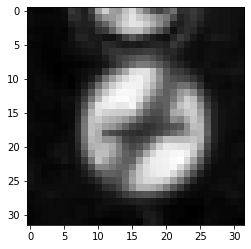

In [0]:
color.rgb2gray(X_train[0]).shape # konwersja trzech kanałów (RGB) do szarości (jeden kanał)
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'));

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)


In [0]:
model = get_cnn_v5((32, 32, 1), num_classes) # zmienily sie kanaly
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.5705 - accuracy: 0.2778 - val_loss: 0.6671 - val_accuracy: 0.7903
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.5684 - accuracy: 0.8156 - val_loss: 0.1440 - val_accuracy: 0.9578
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2594 - accuracy: 0.9179 - val_loss: 0.0643 - val_accuracy: 0.9804
Epoch 4/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1565 - accuracy: 0.9498 - val_loss: 0.0352 - val_accuracy: 0.9903
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1242 - accuracy: 0.9604 - val_loss: 0.0208 - val_accuracy: 0.9940


0.9668934240362812